### Scraping Cryto Currencies in Yahoo Finance

In [1]:
import datetime
from bs4 import BeautifulSoup
import time
import random
import requests

In [2]:
def get_coin_url(url):
    header_list = [
        {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/125'},
        
        {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X) Safari/605'}
    ]
    
    headers = random. choice (header_list)
    r = requests.get(url, headers=headers, timeout=10)
    #print(r.status_code)

    soup = BeautifulSoup(r.content, 'html.parser')

    tbody = soup.find ('tbody')
    trows = tbody.select('tr.yf-ao6als')

    crypto = []

    for trow in trows:
        tdata = trow.select ('td')

        try:
            coin = tdata[1].text.strip()
            
            price = tdata[3].select_one('fin-streamer[data-field="regularMarketPrice"]')
            price = price.text.strip()
            price = float(price. replace(',', '')) if price else None
            
            change = tdata[3].select_one('fin-streamer[data-field="regularMarketChange"]')
            change = change.text.strip()
            change = float(change.replace(',','')) if change else None
            
            change_percent = tdata[3].select_one('fin-streamer[data-field="regularMarketChangePercent"]')
            change_percent = change_percent.text.strip()
            change_percent = float(change_percent.strip('()%')) if change_percent else None
            
            volume = tdata[7].text.strip()
            
            if volume.endswith('B'):
                volume = float(volume.replace('B', '')) * 1000000000
            elif volume.endswith('M'):
                volume = float(volume.replace('M', '')) * 1000000
            else:
                volume = float (volume.replace(',', ''))
        
            date = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
        
            crypto.append ({
            'Coin': coin,
            'Price': price,
            'Change': change,
            'Change %': change_percent,
            'Volume': volume,
            'Date': date
            })
        except Exception as e:
            print(f'Row skipped due to error: {e}')

    return crypto

#get_coin_url('https://finance.yahoo.com/markets/crypto/all/')

In [3]:
import pandas as pd

In [ ]:
start_date = datetime.datetime.now().date()
end_date = start_date + datetime.timedelta(days=3)

while datetime.datetime.now().date() < end_date:
    print(f"\nScraping for: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}")

    crypto_info = get_coin_url('https://finance.yahoo.com/markets/crypto/all/') 
    df = pd.DataFrame(crypto_info)
    df.to_csv(f"crypto_data_history.csv", index=False)

    print("Saved. Waiting 6 hours...\n")
    time.sleep(6 * 60 * 60)

In [3]:
import pandas as pd

In [6]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
crypto = pd.read_csv('crypto_data_history.csv')

In [8]:
cd = crypto.copy()

In [9]:
cd['Date'] = pd.to_datetime(cd['Date'])

In [10]:
# Top 5 Best day and time
cd.nlargest(5, 'Change %')

,Coin,Price,Change,Change %,Volume,Date
48,Avalanche USD,22.88,1.44,6.73,5.265390e+08,2025-08-04 23:05:00
20,Bitcoin Cash USD,575.42,34.94,6.47,3.731480e+08,2025-08-04 16:43:00
32,Lido Staked ETH USD,3712.95,222.39,6.37,6.330200e+07,2025-08-04 23:05:00
47,Wrapped eETH USD,3979.88,235.34,6.28,5.322000e+06,2025-08-04 23:05:00
42,WETH USD,3709.72,211.44,6.04,1.448000e+09,2025-08-04 23:05:00


In [11]:
# Top 5 worst day and t
cd.nsmallest(5, 'Change %')

,Coin,Price,Change,Change %,Volume,Date
167,Sui USD,3.410100,-0.197300,-5.47,1.073000e+09,2025-08-06 00:19:00
159,Dogecoin USD,0.199552,-0.011453,-5.43,1.626000e+09,2025-08-06 00:19:00
174,Avalanche USD,21.840000,-1.230000,-5.34,4.450700e+08,2025-08-06 00:19:00
149,Avalanche USD,21.820000,-1.220000,-5.28,4.459940e+08,2025-08-06 00:13:00
142,Sui USD,3.406300,-0.189200,-5.26,1.072000e+09,2025-08-06 00:13:00


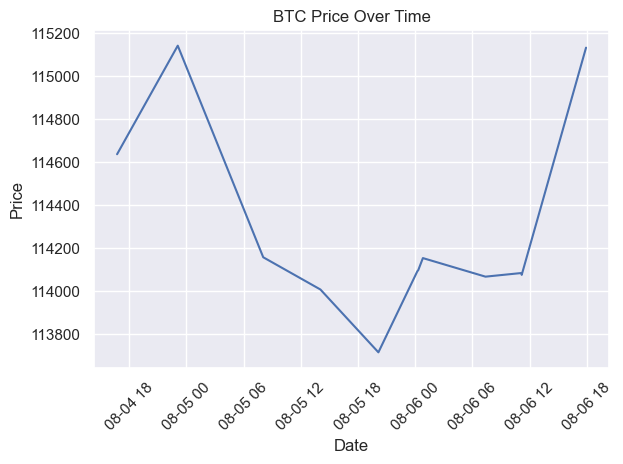

In [12]:
btc = cd[cd['Coin'] == 'Bitcoin USD']
btc_price = btc.groupby('Date')['Price'].sum()

sns.set(style="darkgrid")

sns.lineplot(data=btc_price.reset_index(), x='Date', y='Price')
plt.title('BTC Price Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

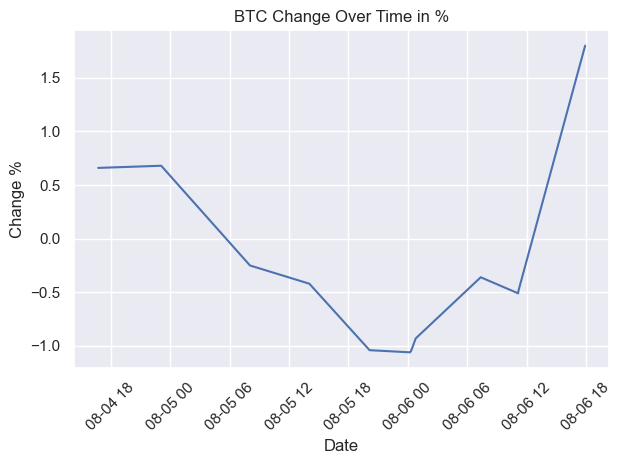

In [13]:
btc_perc_change = btc.groupby('Date')['Change %'].sum()

sns.set(style="darkgrid")

sns.lineplot(data=btc_perc_change.reset_index(), x='Date', y='Change %')
plt.title('BTC Change Over Time in %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

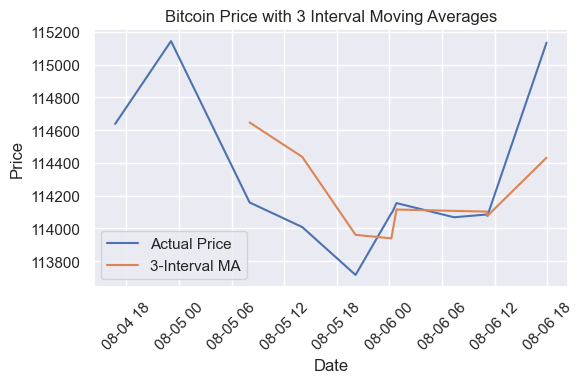

In [14]:
btc = cd[cd['Coin'] == 'Bitcoin USD']
btc_grouped = btc.groupby('Date')['Price'].mean().reset_index()

# Add moving averages
btc_grouped['MA_3'] = btc_grouped['Price'].rolling(window=3).mean()

plt.figure(figsize=(6, 4))
sns.lineplot(data=btc_grouped, x='Date', y='Price', label='Actual Price')
sns.lineplot(data=btc_grouped, x='Date', y='MA_3', label='3-Interval MA')
plt.title('Bitcoin Price with 3 Interval Moving Averages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

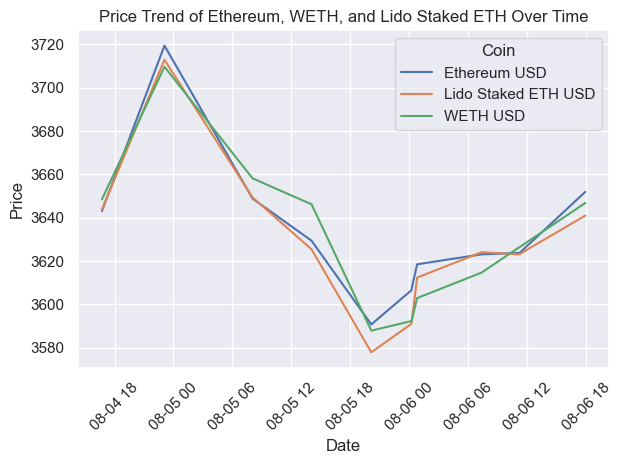

In [15]:
eth_weth_lido = cd[(cd['Coin'] == 'Ethereum USD') | (cd['Coin'] == 'WETH USD') | (cd['Coin'] == 'Lido Staked ETH USD')]
sns.lineplot(data=eth_weth_lido, x='Date', y='Price', hue='Coin')
plt.title('Price Trend of Ethereum, WETH, and Lido Staked ETH Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

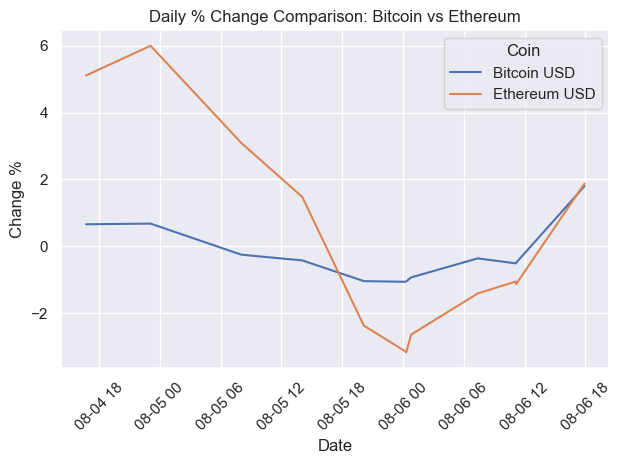

In [16]:
btc_eth = cd[(cd['Coin'] == 'Bitcoin USD') | (cd['Coin'] == 'Ethereum USD')]

sns.lineplot(data=btc_eth, x='Date', y='Change %', hue='Coin')
plt.title('Daily % Change Comparison: Bitcoin vs Ethereum')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
print('Average Timely Change per coin')
cd.groupby('Coin')['Change %'].mean().sort_values(ascending=False).reset_index().head()

Average Timely Change per coin


,Coin,Change %
0,Litecoin USD,5.930000
1,Wrapped TRON USD,0.659167
2,TRON USD,0.610833
3,Wrapped eETH USD,0.360833
4,Lido Staked ETH USD,0.337500


<Axes: xlabel='Volume', ylabel='Change %'>

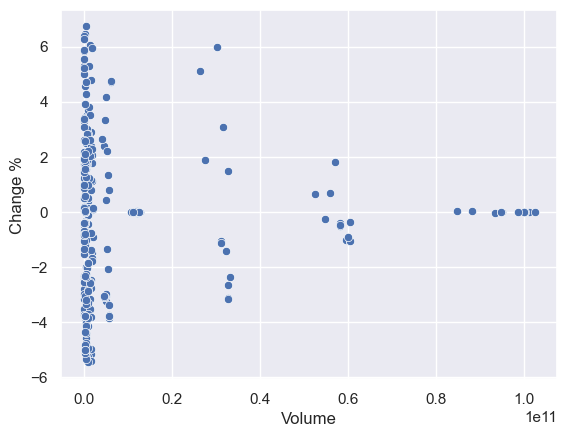

In [18]:
sns.scatterplot(data=cd, x='Volume', y='Change %')

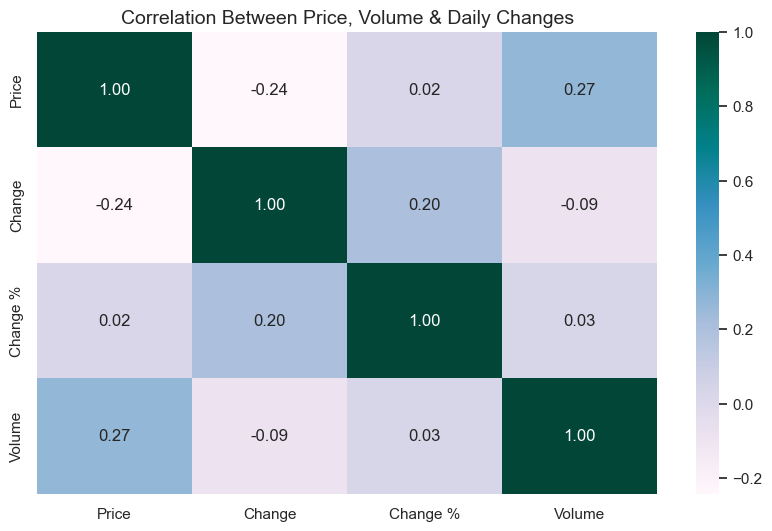

In [19]:
correlation_matrix = cd.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='PuBuGn', fmt='.2f')
plt.title('Correlation Between Price, Volume & Daily Changes', fontsize=14)
plt.show()

In [21]:
print("Price vs Volume: (~0.27) correlation indicates that price tend to rise slightly when volume increases, but the relationship is weak")

Price vs Volume: (~0.27) correlation indicates that price tend to rise slightly when volume increases, but the relationship is weak
